In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Training stuff
from pytorch_metric_learning import losses, distances
from networks.SimpleMLPs import MLPsumV2
import torch.optim as optim
import torch
from tqdm import tqdm

# Evaluation stuff
import pandas as pd
import utils
import copy

In [ ]:
def get_correlated_dataset(n, dependency, mu, input_dim):
    latent = np.random.randn(n, input_dim)
    dependent = latent.dot(dependency)
    scaled = dependent
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

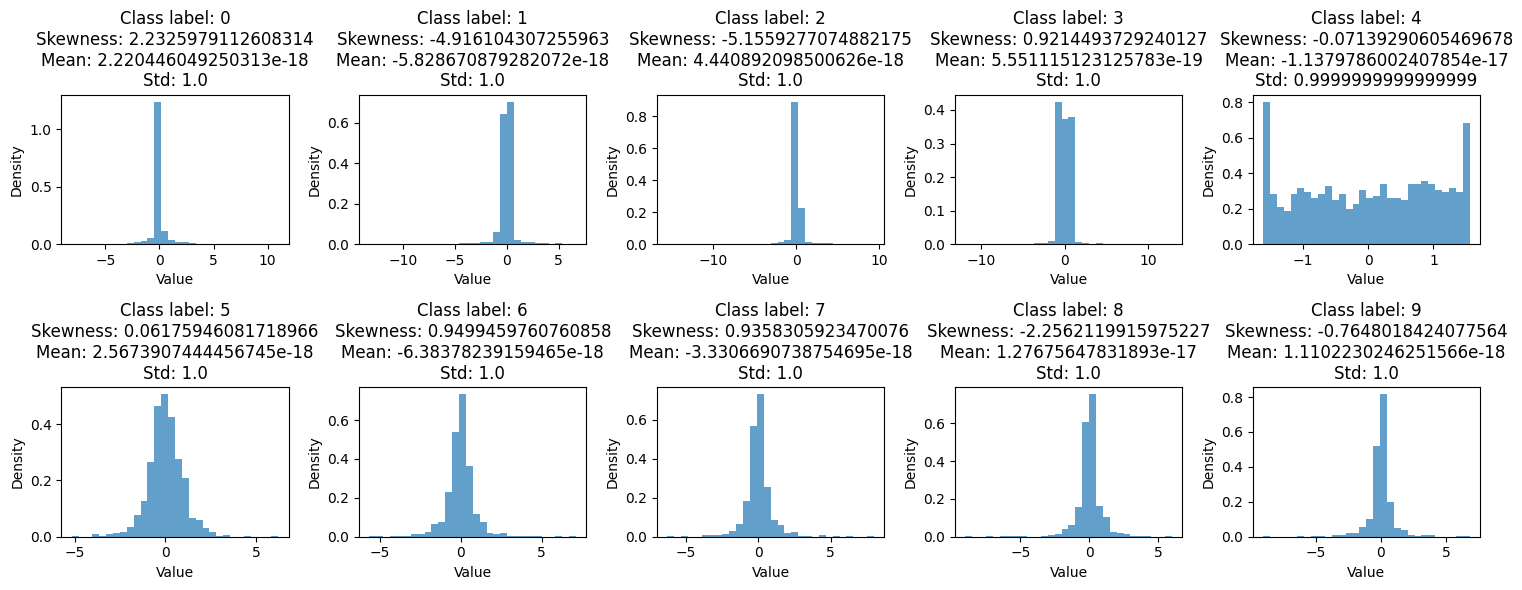

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def generate_batched_data(num_samples, skewness, nr_replicates):
    data = []
    for _ in range(nr_replicates):
        samples = np.random.standard_normal(num_samples)
        samples = samples + skewness * (samples ** 3)
        data.append(samples)

    # Convert data to a numpy array and reshape for batching
    batch = np.array(data)

    distribution_means = np.mean(batch, axis=1)
    distribution_stds = np.std(batch, axis=1)

    norm_batch = (batch - distribution_means[:, np.newaxis]) / distribution_stds[:, np.newaxis]

    return norm_batch[:, :, np.newaxis]


# Parameters
num_samples = 800
num_distributions = 10
skewness_values = np.linspace(-1, 1, num_distributions)  # Varying skewness values
nr_replicates = 4  # Number of samples per class or distribution

# Create a 2x5 grid of plots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, skewness in enumerate(skewness_values):
    # Generate skewed data with varying skewness values and different points
    skewed_data = generate_batched_data(num_samples, skewness, nr_replicates)

    # Plot the distribution
    axes[i].hist(skewed_data[0], bins=30, density=True, alpha=0.7)
    axes[i].set_title(f"Class label: {i}\nSkewness: {scipy.stats.skew(skewed_data[0])[0]}\nMean: {np.mean(skewed_data)}\nStd: {np.std(skewed_data)}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

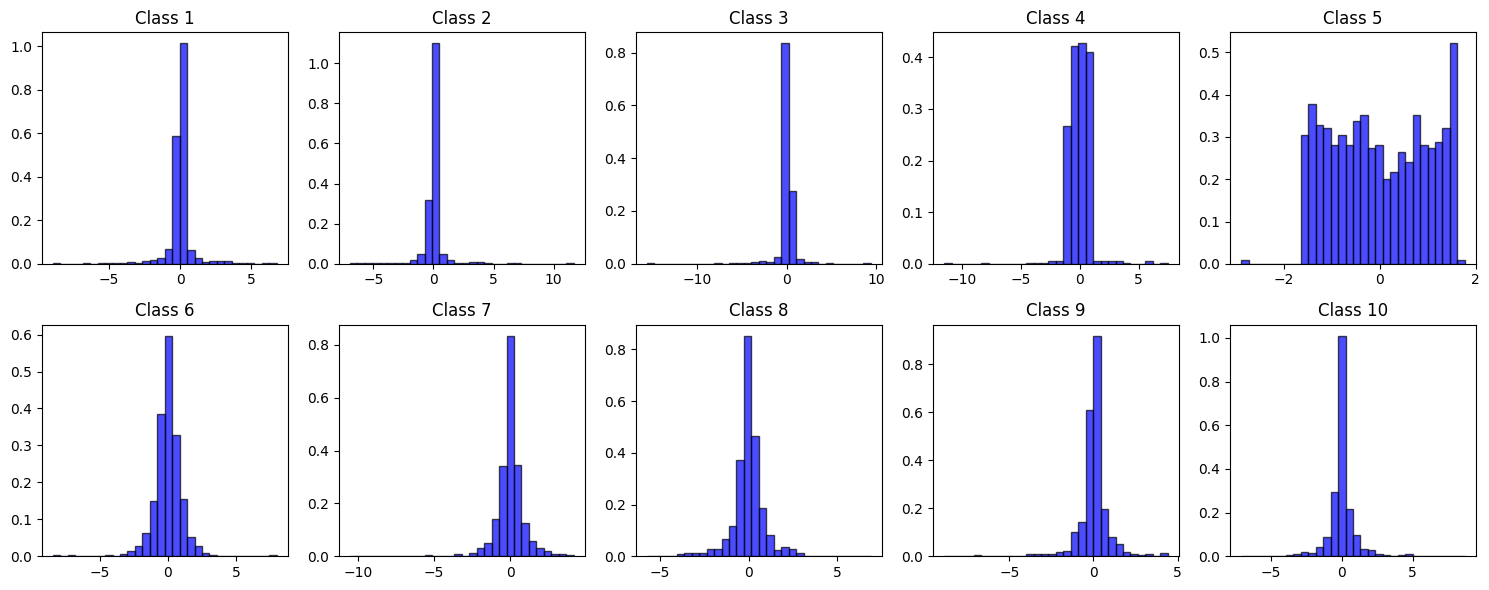

In [63]:

# Create a 2x5 grid of plots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Create a table to display statistics
stat_table_data = []

for i, skewness in enumerate(skewness_values):
    # Generate skewed data with varying skewness values and different points
    skewed_data = generate_batched_data(num_samples, skewness, nr_replicates)

    # Plot the distribution
    axes[i].hist(skewed_data[0], bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Class {i+1}")
    axes[i].grid(False)

    # Collect statistics for the table
    skewness_value = scipy.stats.skew(skewed_data[0]).round(2)
    mean_value = np.mean(skewed_data).round(2)
    std_value = np.std(skewed_data).round(2)
    stat_table_data.append([skewness_value, mean_value, std_value])


plt.tight_layout()
plt.show()

(0.0, 1.0, 0.0, 1.0)

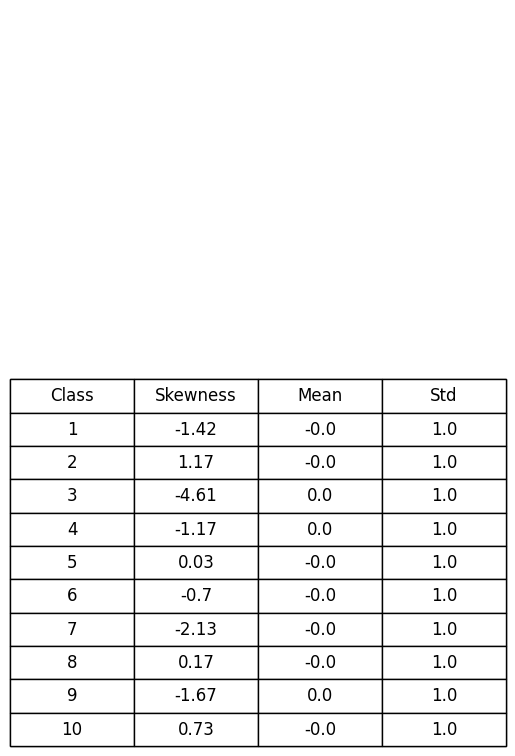

In [71]:
fig, ax = plt.subplots()
table_rows = []
for i, (skewness, mean, std) in enumerate(stat_table_data):
    table_rows.append([i+1, f'{skewness[0]}', f'{mean}', f'{std}'])

# Create a table on the side for statistics
stat_table = plt.table(cellText=table_rows,
                       cellLoc='center',
                       colLabels=['Class', 'Skewness', 'Mean', 'Std'],
                       )
stat_table.auto_set_font_size(False)
stat_table.set_fontsize(12)
stat_table.scale(1, 2)  # Adjust the scaling as needed

plt.gca().add_table(stat_table)
plt.axis('off')


In [ ]:
nr_replicates = 4
num_samples = 800
num_distributions = 10
skewness_values = np.linspace(-1, 1, num_distributions)  # Varying skewness values

train_samples = []
val_samples = []

for i, skewness in enumerate(skewness_values):
    data = generate_batched_data(num_samples, skewness, nr_replicates)

    if i < 6:
        train_samples.append({'data':data,
         'label': [i]*nr_replicates})
    else:
        val_samples.append({'data': data,
             'label': [i]*nr_replicates})

print("nr. train samples:", len(train_samples), "nr. val samples:", len(val_samples), "data shape:", data.shape)

nr. train samples: 6 nr. val samples: 4 data shape: (4, 800, 1)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Shuffle the training samples
import random
random.shuffle(train_samples)

# Batch size
bs = 24

# Lists to store data and labels for each batch
batched_data = []
batched_labels = []

for idx in range(0, len(train_samples), bs):
    batch_data = []
    batch_label = []

    # Collect data and labels for the current batch
    for sample in train_samples[idx:idx + bs]:
        batch_data.append(torch.tensor(sample['data'], dtype=torch.float32))
        batch_label.append(torch.tensor(sample['label'], dtype=torch.int64))

    batched_data.append(torch.cat(batch_data))
    batched_labels.append(torch.cat(batch_label))

# Concatenate batched data and labels
batched_data = torch.cat(batched_data)
batched_labels = torch.cat(batched_labels)

# Create a DataLoader for batching
train_dataset = TensorDataset(batched_data, batched_labels)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)


In [ ]:
train_model = True  # TODO hyperparameter
load_pretrained_model = True  # TODO hyperparameter
plot_distributions = True  # TODO hyperparameter
standardize = False  # TODO hyperparameter

input_dim = 1

np.random.seed(42)

apmlp = []
apbm = []

##% TRAINING
if train_model:
    model = MLPsumV2(input_dim=input_dim, latent_dim=16, output_dim=4,  # latent_dim=64
                     k=8, dropout=0, cell_layers=1,  # k=4
                     proj_layers=2, reduction='sum')
    optimizer = optim.AdamW(model.parameters(), lr=1e-6)
    loss_func = losses.SupConLoss(distance=distances.CosineSimilarity())

    epochs = 5000

    for e in range(epochs):
        model.train()
        tr_loss = 0.0
        for points, labels in train_loader:
            feats, _ = model(points)

            tr_loss_tmp = loss_func(feats, labels)
            tr_loss += tr_loss_tmp.item()

            tr_loss_tmp.backward()
            optimizer.step()
            optimizer.zero_grad()

        tr_loss /= (idx + 1)


        # Validation
        model.eval()
        best_val = np.inf
        val_loss = 0.0
        with torch.no_grad():
            points = torch.concatenate([torch.tensor(x['data'], dtype=torch.float32) for x in val_samples])
            labels = torch.concatenate([torch.tensor(x['label'], dtype=torch.int16) for x in val_samples])
            feats, _ = model(points)

            val_loss_tmp = loss_func(feats, labels)
            val_loss += val_loss_tmp.item()

        if val_loss < best_val:
            best_val = val_loss
            best_model = copy.deepcopy(model)

        print(f"Epoch {e}. Training loss: {tr_loss}. Validation loss: {val_loss}.")


Epoch 0. Training loss: 0.7775054574012756. Validation loss: 2.7070956230163574.
Epoch 1. Training loss: 0.777502715587616. Validation loss: 2.707095146179199.
Epoch 2. Training loss: 0.7774999141693115. Validation loss: 2.70709490776062.
Epoch 3. Training loss: 0.7774972319602966. Validation loss: 2.707094669342041.
Epoch 4. Training loss: 0.777494490146637. Validation loss: 2.707094192504883.
Epoch 5. Training loss: 0.7774917483329773. Validation loss: 2.7070939540863037.
Epoch 6. Training loss: 0.7774888873100281. Validation loss: 2.7070937156677246.
Epoch 7. Training loss: 0.7774860858917236. Validation loss: 2.7070932388305664.
Epoch 8. Training loss: 0.7774832844734192. Validation loss: 2.7070932388305664.
Epoch 9. Training loss: 0.7774805426597595. Validation loss: 2.707092761993408.
Epoch 10. Training loss: 0.7774777412414551. Validation loss: 2.707092523574829.
Epoch 11. Training loss: 0.7774749398231506. Validation loss: 2.70709228515625.
Epoch 12. Training loss: 0.7774722576

Epoch 167. Training loss: 0.7770349383354187. Validation loss: 2.7070462703704834.
Epoch 168. Training loss: 0.7770323753356934. Validation loss: 2.7070460319519043.
Epoch 169. Training loss: 0.7770295143127441. Validation loss: 2.707045555114746.
Epoch 170. Training loss: 0.7770268321037292. Validation loss: 2.707045316696167.
Epoch 171. Training loss: 0.7770242094993591. Validation loss: 2.707044839859009.
Epoch 172. Training loss: 0.7770214080810547. Validation loss: 2.7070446014404297.
Epoch 173. Training loss: 0.7770187854766846. Validation loss: 2.7070441246032715.
Epoch 174. Training loss: 0.7770159840583801. Validation loss: 2.7070438861846924.
Epoch 175. Training loss: 0.7770133018493652. Validation loss: 2.707043409347534.
Epoch 176. Training loss: 0.7770106792449951. Validation loss: 2.707043170928955.
Epoch 177. Training loss: 0.7770079970359802. Validation loss: 2.707042694091797.
Epoch 178. Training loss: 0.7770052552223206. Validation loss: 2.7070422172546387.
Epoch 179.

Epoch 355. Training loss: 0.7765085697174072. Validation loss: 2.706979274749756.
Epoch 356. Training loss: 0.7765057682991028. Validation loss: 2.7069787979125977.
Epoch 357. Training loss: 0.7765028476715088. Validation loss: 2.7069783210754395.
Epoch 358. Training loss: 0.7764999270439148. Validation loss: 2.706977605819702.
Epoch 359. Training loss: 0.7764971256256104. Validation loss: 2.706977605819702.
Epoch 360. Training loss: 0.7764942646026611. Validation loss: 2.706977367401123.
Epoch 361. Training loss: 0.7764912247657776. Validation loss: 2.706976890563965.
Epoch 362. Training loss: 0.7764884829521179. Validation loss: 2.7069766521453857.
Epoch 363. Training loss: 0.7764855027198792. Validation loss: 2.7069761753082275.
Epoch 364. Training loss: 0.7764825820922852. Validation loss: 2.7069759368896484.
Epoch 365. Training loss: 0.7764796614646912. Validation loss: 2.7069754600524902.
Epoch 366. Training loss: 0.7764768600463867. Validation loss: 2.706974983215332.
Epoch 367.

Epoch 529. Training loss: 0.775996744632721. Validation loss: 2.7069144248962402.
Epoch 530. Training loss: 0.7759937644004822. Validation loss: 2.7069144248962402.
Epoch 531. Training loss: 0.7759907245635986. Validation loss: 2.706913948059082.
Epoch 532. Training loss: 0.7759878039360046. Validation loss: 2.706913709640503.
Epoch 533. Training loss: 0.7759847640991211. Validation loss: 2.7069129943847656.
Epoch 534. Training loss: 0.7759817242622375. Validation loss: 2.7069127559661865.
Epoch 535. Training loss: 0.7759787440299988. Validation loss: 2.7069125175476074.
Epoch 536. Training loss: 0.7759758830070496. Validation loss: 2.70691180229187.
Epoch 537. Training loss: 0.775972843170166. Validation loss: 2.706911563873291.
Epoch 538. Training loss: 0.7759697437286377. Validation loss: 2.706911325454712.
Epoch 539. Training loss: 0.7759668231010437. Validation loss: 2.706911087036133.
Epoch 540. Training loss: 0.7759637832641602. Validation loss: 2.7069101333618164.
Epoch 541. Tr

Epoch 716. Training loss: 0.775425910949707. Validation loss: 2.7068428993225098.
Epoch 717. Training loss: 0.7754228115081787. Validation loss: 2.7068424224853516.
Epoch 718. Training loss: 0.7754197120666504. Validation loss: 2.7068419456481934.
Epoch 719. Training loss: 0.7754166126251221. Validation loss: 2.7068417072296143.
Epoch 720. Training loss: 0.7754133343696594. Validation loss: 2.706841468811035.
Epoch 721. Training loss: 0.7754104137420654. Validation loss: 2.706840991973877.
Epoch 722. Training loss: 0.7754073143005371. Validation loss: 2.7068402767181396.
Epoch 723. Training loss: 0.7754040360450745. Validation loss: 2.7068402767181396.
Epoch 724. Training loss: 0.7754010558128357. Validation loss: 2.7068397998809814.
Epoch 725. Training loss: 0.7753979563713074. Validation loss: 2.7068395614624023.
Epoch 726. Training loss: 0.7753947377204895. Validation loss: 2.706838846206665.
Epoch 727. Training loss: 0.7753916382789612. Validation loss: 2.706838846206665.
Epoch 728

Epoch 910. Training loss: 0.774810254573822. Validation loss: 2.7067620754241943.
Epoch 911. Training loss: 0.7748069763183594. Validation loss: 2.7067618370056152.
Epoch 912. Training loss: 0.7748036980628967. Validation loss: 2.706761360168457.
Epoch 913. Training loss: 0.7748003602027893. Validation loss: 2.706760883331299.
Epoch 914. Training loss: 0.774797260761261. Validation loss: 2.7067604064941406.
Epoch 915. Training loss: 0.7747940421104431. Validation loss: 2.7067599296569824.
Epoch 916. Training loss: 0.7747907042503357. Validation loss: 2.706759214401245.
Epoch 917. Training loss: 0.7747876048088074. Validation loss: 2.706758975982666.
Epoch 918. Training loss: 0.7747843265533447. Validation loss: 2.7067582607269287.
Epoch 919. Training loss: 0.7747810482978821. Validation loss: 2.7067575454711914.
Epoch 920. Training loss: 0.7747777104377747. Validation loss: 2.7067573070526123.
Epoch 921. Training loss: 0.7747745513916016. Validation loss: 2.706756591796875.
Epoch 922. 

Epoch 1103. Training loss: 0.7741708755493164. Validation loss: 2.706651210784912.
Epoch 1104. Training loss: 0.774167537689209. Validation loss: 2.706650495529175.
Epoch 1105. Training loss: 0.7741641402244568. Validation loss: 2.7066500186920166.
Epoch 1106. Training loss: 0.7741608023643494. Validation loss: 2.7066493034362793.
Epoch 1107. Training loss: 0.7741573452949524. Validation loss: 2.706648588180542.
Epoch 1108. Training loss: 0.7741539478302002. Validation loss: 2.7066478729248047.
Epoch 1109. Training loss: 0.774150550365448. Validation loss: 2.7066471576690674.
Epoch 1110. Training loss: 0.774147093296051. Validation loss: 2.706646680831909.
Epoch 1111. Training loss: 0.7741437554359436. Validation loss: 2.706645965576172.
Epoch 1112. Training loss: 0.7741403579711914. Validation loss: 2.7066452503204346.
Epoch 1113. Training loss: 0.7741369605064392. Validation loss: 2.706644296646118.
Epoch 1114. Training loss: 0.7741336226463318. Validation loss: 2.706644058227539.
Ep

Epoch 1295. Training loss: 0.7735260128974915. Validation loss: 2.7065248489379883.
Epoch 1296. Training loss: 0.773522675037384. Validation loss: 2.706523895263672.
Epoch 1297. Training loss: 0.7735192775726318. Validation loss: 2.7065231800079346.
Epoch 1298. Training loss: 0.7735159993171692. Validation loss: 2.7065227031707764.
Epoch 1299. Training loss: 0.7735126614570618. Validation loss: 2.70652174949646.
Epoch 1300. Training loss: 0.7735092639923096. Validation loss: 2.7065212726593018.
Epoch 1301. Training loss: 0.7735059261322021. Validation loss: 2.7065205574035645.
Epoch 1302. Training loss: 0.7735025882720947. Validation loss: 2.7065203189849854.
Epoch 1303. Training loss: 0.7734993100166321. Validation loss: 2.706519365310669.
Epoch 1304. Training loss: 0.7734959125518799. Validation loss: 2.7065186500549316.
Epoch 1305. Training loss: 0.7734925150871277. Validation loss: 2.7065179347991943.
Epoch 1306. Training loss: 0.773489236831665. Validation loss: 2.706517457962036.

Epoch 1480. Training loss: 0.7729015946388245. Validation loss: 2.7063865661621094.
Epoch 1481. Training loss: 0.772898256778717. Validation loss: 2.706385850906372.
Epoch 1482. Training loss: 0.7728947997093201. Validation loss: 2.706385374069214.
Epoch 1483. Training loss: 0.7728913426399231. Validation loss: 2.7063846588134766.
Epoch 1484. Training loss: 0.7728879451751709. Validation loss: 2.70638370513916.
Epoch 1485. Training loss: 0.7728845477104187. Validation loss: 2.7063827514648438.
Epoch 1486. Training loss: 0.7728812098503113. Validation loss: 2.7063825130462646.
Epoch 1487. Training loss: 0.7728778719902039. Validation loss: 2.706381320953369.
Epoch 1488. Training loss: 0.7728743553161621. Validation loss: 2.706380844116211.
Epoch 1489. Training loss: 0.7728710174560547. Validation loss: 2.7063796520233154.
Epoch 1490. Training loss: 0.7728675007820129. Validation loss: 2.7063791751861572.
Epoch 1491. Training loss: 0.7728641629219055. Validation loss: 2.70637845993042.
E

Epoch 1673. Training loss: 0.7722353935241699. Validation loss: 2.7062363624572754.
Epoch 1674. Training loss: 0.7722318768501282. Validation loss: 2.706235885620117.
Epoch 1675. Training loss: 0.7722284197807312. Validation loss: 2.70623517036438.
Epoch 1676. Training loss: 0.7722249031066895. Validation loss: 2.7062346935272217.
Epoch 1677. Training loss: 0.7722213864326477. Validation loss: 2.7062337398529053.
Epoch 1678. Training loss: 0.7722178101539612. Validation loss: 2.706233263015747.
Epoch 1679. Training loss: 0.772214412689209. Validation loss: 2.7062325477600098.
Epoch 1680. Training loss: 0.7722108364105225. Validation loss: 2.7062318325042725.
Epoch 1681. Training loss: 0.7722073197364807. Validation loss: 2.7062313556671143.
Epoch 1682. Training loss: 0.7722038626670837. Validation loss: 2.706230640411377.
Epoch 1683. Training loss: 0.7722002863883972. Validation loss: 2.7062296867370605.
Epoch 1684. Training loss: 0.7721967697143555. Validation loss: 2.7062292098999023

Epoch 1860. Training loss: 0.7715713977813721. Validation loss: 2.7061116695404053.
Epoch 1861. Training loss: 0.7715677618980408. Validation loss: 2.706110954284668.
Epoch 1862. Training loss: 0.771564245223999. Validation loss: 2.7061102390289307.
Epoch 1863. Training loss: 0.7715606093406677. Validation loss: 2.7061097621917725.
Epoch 1864. Training loss: 0.7715569138526917. Validation loss: 2.706109046936035.
Epoch 1865. Training loss: 0.7715532779693604. Validation loss: 2.706108570098877.
Epoch 1866. Training loss: 0.7715497612953186. Validation loss: 2.7061071395874023.
Epoch 1867. Training loss: 0.7715460658073425. Validation loss: 2.7061069011688232.
Epoch 1868. Training loss: 0.771542489528656. Validation loss: 2.706105947494507.
Epoch 1869. Training loss: 0.7715389728546143. Validation loss: 2.7061054706573486.
Epoch 1870. Training loss: 0.7715353965759277. Validation loss: 2.7061047554016113.
Epoch 1871. Training loss: 0.7715317606925964. Validation loss: 2.706104278564453.

Epoch 2048. Training loss: 0.7709202170372009. Validation loss: 2.7059950828552246.
Epoch 2049. Training loss: 0.770916759967804. Validation loss: 2.7059948444366455.
Epoch 2050. Training loss: 0.7709133625030518. Validation loss: 2.70599365234375.
Epoch 2051. Training loss: 0.7709100246429443. Validation loss: 2.70599365234375.
Epoch 2052. Training loss: 0.7709066867828369. Validation loss: 2.705993175506592.
Epoch 2053. Training loss: 0.7709031105041504. Validation loss: 2.7059926986694336.
Epoch 2054. Training loss: 0.770899772644043. Validation loss: 2.7059919834136963.
Epoch 2055. Training loss: 0.7708964347839355. Validation loss: 2.705991506576538.
Epoch 2056. Training loss: 0.7708929181098938. Validation loss: 2.70599102973938.
Epoch 2057. Training loss: 0.7708895802497864. Validation loss: 2.7059903144836426.
Epoch 2058. Training loss: 0.7708861827850342. Validation loss: 2.7059895992279053.
Epoch 2059. Training loss: 0.7708828449249268. Validation loss: 2.705989360809326.
Epo

Epoch 2213. Training loss: 0.7703542113304138. Validation loss: 2.7059080600738525.
Epoch 2214. Training loss: 0.7703506350517273. Validation loss: 2.7059073448181152.
Epoch 2215. Training loss: 0.7703471183776855. Validation loss: 2.705906867980957.
Epoch 2216. Training loss: 0.7703437209129333. Validation loss: 2.705906391143799.
Epoch 2217. Training loss: 0.7703402042388916. Validation loss: 2.7059059143066406.
Epoch 2218. Training loss: 0.7703366875648499. Validation loss: 2.7059051990509033.
Epoch 2219. Training loss: 0.7703332304954529. Validation loss: 2.705904483795166.
Epoch 2220. Training loss: 0.7703297138214111. Validation loss: 2.705904006958008.
Epoch 2221. Training loss: 0.7703263163566589. Validation loss: 2.7059035301208496.
Epoch 2222. Training loss: 0.770322859287262. Validation loss: 2.7059030532836914.
Epoch 2223. Training loss: 0.7703192830085754. Validation loss: 2.705902576446533.
Epoch 2224. Training loss: 0.7703158259391785. Validation loss: 2.705902099609375.

Epoch 2393. Training loss: 0.7697209715843201. Validation loss: 2.7058098316192627.
Epoch 2394. Training loss: 0.7697173953056335. Validation loss: 2.7058091163635254.
Epoch 2395. Training loss: 0.769713819026947. Validation loss: 2.7058088779449463.
Epoch 2396. Training loss: 0.7697103023529053. Validation loss: 2.705808639526367.
Epoch 2397. Training loss: 0.769706666469574. Validation loss: 2.7058074474334717.
Epoch 2398. Training loss: 0.7697030901908875. Validation loss: 2.7058074474334717.
Epoch 2399. Training loss: 0.7696996331214905. Validation loss: 2.7058067321777344.
Epoch 2400. Training loss: 0.7696959972381592. Validation loss: 2.705806016921997.
Epoch 2401. Training loss: 0.7696924209594727. Validation loss: 2.705805540084839.
Epoch 2402. Training loss: 0.7696889042854309. Validation loss: 2.7058048248291016.
Epoch 2403. Training loss: 0.7696852684020996. Validation loss: 2.7058048248291016.
Epoch 2404. Training loss: 0.7696816921234131. Validation loss: 2.705803632736206

Epoch 2572. Training loss: 0.7690736651420593. Validation loss: 2.705739736557007.
Epoch 2573. Training loss: 0.7690699696540833. Validation loss: 2.7057394981384277.
Epoch 2574. Training loss: 0.769066333770752. Validation loss: 2.7057392597198486.
Epoch 2575. Training loss: 0.7690625786781311. Validation loss: 2.7057390213012695.
Epoch 2576. Training loss: 0.7690590023994446. Validation loss: 2.7057387828826904.
Epoch 2577. Training loss: 0.7690553069114685. Validation loss: 2.705738067626953.
Epoch 2578. Training loss: 0.769051730632782. Validation loss: 2.705737829208374.
Epoch 2579. Training loss: 0.7690480351448059. Validation loss: 2.705737352371216.
Epoch 2580. Training loss: 0.7690442204475403. Validation loss: 2.7057368755340576.
Epoch 2581. Training loss: 0.769040584564209. Validation loss: 2.7057363986968994.
Epoch 2582. Training loss: 0.7690368294715881. Validation loss: 2.7057363986968994.
Epoch 2583. Training loss: 0.7690333724021912. Validation loss: 2.7057361602783203.

Epoch 2757. Training loss: 0.7683849930763245. Validation loss: 2.705669641494751.
Epoch 2758. Training loss: 0.7683812975883484. Validation loss: 2.7056689262390137.
Epoch 2759. Training loss: 0.7683773636817932. Validation loss: 2.7056689262390137.
Epoch 2760. Training loss: 0.7683737874031067. Validation loss: 2.7056682109832764.
Epoch 2761. Training loss: 0.7683699131011963. Validation loss: 2.7056679725646973.
Epoch 2762. Training loss: 0.7683660984039307. Validation loss: 2.705667495727539.
Epoch 2763. Training loss: 0.7683623433113098. Validation loss: 2.70566725730896.
Epoch 2764. Training loss: 0.7683585286140442. Validation loss: 2.7056665420532227.
Epoch 2765. Training loss: 0.7683547139167786. Validation loss: 2.7056660652160645.
Epoch 2766. Training loss: 0.7683510184288025. Validation loss: 2.7056660652160645.
Epoch 2767. Training loss: 0.7683472633361816. Validation loss: 2.7056655883789062.
Epoch 2768. Training loss: 0.768343448638916. Validation loss: 2.705665111541748

Epoch 2925. Training loss: 0.7677383422851562. Validation loss: 2.705603837966919.
Epoch 2926. Training loss: 0.7677344679832458. Validation loss: 2.705603837966919.
Epoch 2927. Training loss: 0.7677305340766907. Validation loss: 2.7056033611297607.
Epoch 2928. Training loss: 0.767726480960846. Validation loss: 2.7056026458740234.
Epoch 2929. Training loss: 0.7677226662635803. Validation loss: 2.7056021690368652.
Epoch 2930. Training loss: 0.7677187919616699. Validation loss: 2.705601930618286.
Epoch 2931. Training loss: 0.7677149176597595. Validation loss: 2.705601692199707.
Epoch 2932. Training loss: 0.7677109241485596. Validation loss: 2.705601453781128.
Epoch 2933. Training loss: 0.7677070498466492. Validation loss: 2.7056009769439697.
Epoch 2934. Training loss: 0.767703115940094. Validation loss: 2.7056007385253906.
Epoch 2935. Training loss: 0.7676992416381836. Validation loss: 2.7056000232696533.
Epoch 2936. Training loss: 0.7676952481269836. Validation loss: 2.705599546432495.


Epoch 3106. Training loss: 0.7670526504516602. Validation loss: 2.705528736114502.
Epoch 3107. Training loss: 0.7670490741729736. Validation loss: 2.705528497695923.
Epoch 3108. Training loss: 0.7670454978942871. Validation loss: 2.7055280208587646.
Epoch 3109. Training loss: 0.7670416831970215. Validation loss: 2.7055275440216064.
Epoch 3110. Training loss: 0.767038106918335. Validation loss: 2.7055273056030273.
Epoch 3111. Training loss: 0.7670345306396484. Validation loss: 2.705526828765869.
Epoch 3112. Training loss: 0.7670309543609619. Validation loss: 2.705526351928711.
Epoch 3113. Training loss: 0.7670273184776306. Validation loss: 2.7055256366729736.
Epoch 3114. Training loss: 0.7670236229896545. Validation loss: 2.7055253982543945.
Epoch 3115. Training loss: 0.767020046710968. Validation loss: 2.7055249214172363.
Epoch 3116. Training loss: 0.7670164704322815. Validation loss: 2.7055246829986572.
Epoch 3117. Training loss: 0.7670127749443054. Validation loss: 2.705524206161499.

Epoch 3293. Training loss: 0.7663640975952148. Validation loss: 2.705447196960449.
Epoch 3294. Training loss: 0.7663602828979492. Validation loss: 2.705446481704712.
Epoch 3295. Training loss: 0.7663565278053284. Validation loss: 2.7054460048675537.
Epoch 3296. Training loss: 0.7663528919219971. Validation loss: 2.7054455280303955.
Epoch 3297. Training loss: 0.7663490772247314. Validation loss: 2.7054452896118164.
Epoch 3298. Training loss: 0.7663453221321106. Validation loss: 2.705444812774658.
Epoch 3299. Training loss: 0.7663416266441345. Validation loss: 2.7054443359375.
Epoch 3300. Training loss: 0.7663378715515137. Validation loss: 2.705443859100342.
Epoch 3301. Training loss: 0.7663341164588928. Validation loss: 2.7054433822631836.
Epoch 3302. Training loss: 0.7663303017616272. Validation loss: 2.7054429054260254.
Epoch 3303. Training loss: 0.7663266658782959. Validation loss: 2.705442428588867.
Epoch 3304. Training loss: 0.7663228511810303. Validation loss: 2.705441951751709.
E

Epoch 3483. Training loss: 0.7656407952308655. Validation loss: 2.705362558364868.
Epoch 3484. Training loss: 0.765637218952179. Validation loss: 2.705361843109131.
Epoch 3485. Training loss: 0.7656334042549133. Validation loss: 2.7053613662719727.
Epoch 3486. Training loss: 0.765629768371582. Validation loss: 2.7053608894348145.
Epoch 3487. Training loss: 0.7656260132789612. Validation loss: 2.7053604125976562.
Epoch 3488. Training loss: 0.7656223177909851. Validation loss: 2.705359935760498.
Epoch 3489. Training loss: 0.7656185030937195. Validation loss: 2.705359935760498.
Epoch 3490. Training loss: 0.7656148076057434. Validation loss: 2.7053592205047607.
Epoch 3491. Training loss: 0.7656111121177673. Validation loss: 2.7053587436676025.
Epoch 3492. Training loss: 0.7656074166297913. Validation loss: 2.7053585052490234.
Epoch 3493. Training loss: 0.7656037211418152. Validation loss: 2.705357551574707.
Epoch 3494. Training loss: 0.7655999064445496. Validation loss: 2.705357074737549.


Epoch 3669. Training loss: 0.7649542689323425. Validation loss: 2.7052736282348633.
Epoch 3670. Training loss: 0.7649505138397217. Validation loss: 2.705272912979126.
Epoch 3671. Training loss: 0.7649468779563904. Validation loss: 2.7052724361419678.
Epoch 3672. Training loss: 0.7649431824684143. Validation loss: 2.7052721977233887.
Epoch 3673. Training loss: 0.7649394869804382. Validation loss: 2.7052712440490723.
Epoch 3674. Training loss: 0.7649357914924622. Validation loss: 2.7052712440490723.
Epoch 3675. Training loss: 0.7649321556091309. Validation loss: 2.705270528793335.
Epoch 3676. Training loss: 0.76492840051651. Validation loss: 2.7052700519561768.
Epoch 3677. Training loss: 0.7649247646331787. Validation loss: 2.7052695751190186.
Epoch 3678. Training loss: 0.7649210095405579. Validation loss: 2.7052688598632812.
Epoch 3679. Training loss: 0.7649173140525818. Validation loss: 2.7052688598632812.
Epoch 3680. Training loss: 0.7649136185646057. Validation loss: 2.70526790618896

Epoch 3855. Training loss: 0.7642569541931152. Validation loss: 2.7051820755004883.
Epoch 3856. Training loss: 0.7642531394958496. Validation loss: 2.70518159866333.
Epoch 3857. Training loss: 0.764249324798584. Validation loss: 2.705181121826172.
Epoch 3858. Training loss: 0.7642455101013184. Validation loss: 2.7051804065704346.
Epoch 3859. Training loss: 0.764241635799408. Validation loss: 2.7051799297332764.
Epoch 3860. Training loss: 0.7642378807067871. Validation loss: 2.705179452896118.
Epoch 3861. Training loss: 0.7642340660095215. Validation loss: 2.705178737640381.
Epoch 3862. Training loss: 0.7642302513122559. Validation loss: 2.7051782608032227.
Epoch 3863. Training loss: 0.7642264366149902. Validation loss: 2.7051777839660645.
Epoch 3864. Training loss: 0.7642226219177246. Validation loss: 2.7051773071289062.
Epoch 3865. Training loss: 0.764218807220459. Validation loss: 2.705177068710327.
Epoch 3866. Training loss: 0.7642149329185486. Validation loss: 2.705176591873169.
Ep

Epoch 4049. Training loss: 0.7635032534599304. Validation loss: 2.7050845623016357.
Epoch 4050. Training loss: 0.7634992599487305. Validation loss: 2.7050843238830566.
Epoch 4051. Training loss: 0.7634952664375305. Validation loss: 2.7050838470458984.
Epoch 4052. Training loss: 0.7634913325309753. Validation loss: 2.7050833702087402.
Epoch 4053. Training loss: 0.7634873390197754. Validation loss: 2.705082893371582.
Epoch 4054. Training loss: 0.7634835243225098. Validation loss: 2.7050821781158447.
Epoch 4055. Training loss: 0.763479471206665. Validation loss: 2.7050817012786865.
Epoch 4056. Training loss: 0.7634754776954651. Validation loss: 2.7050812244415283.
Epoch 4057. Training loss: 0.7634714245796204. Validation loss: 2.70508074760437.
Epoch 4058. Training loss: 0.7634676098823547. Validation loss: 2.705080032348633.
Epoch 4059. Training loss: 0.7634636759757996. Validation loss: 2.7050795555114746.
Epoch 4060. Training loss: 0.7634596824645996. Validation loss: 2.705079317092895

Epoch 4243. Training loss: 0.7627211213111877. Validation loss: 2.7049856185913086.
Epoch 4244. Training loss: 0.7627169489860535. Validation loss: 2.7049849033355713.
Epoch 4245. Training loss: 0.7627129554748535. Validation loss: 2.7049851417541504.
Epoch 4246. Training loss: 0.762708842754364. Validation loss: 2.704984188079834.
Epoch 4247. Training loss: 0.7627046704292297. Validation loss: 2.704983949661255.
Epoch 4248. Training loss: 0.7627005577087402. Validation loss: 2.7049829959869385.
Epoch 4249. Training loss: 0.7626964449882507. Validation loss: 2.7049825191497803.
Epoch 4250. Training loss: 0.762692391872406. Validation loss: 2.704982280731201.
Epoch 4251. Training loss: 0.7626882195472717. Validation loss: 2.704981803894043.
Epoch 4252. Training loss: 0.762684166431427. Validation loss: 2.7049810886383057.
Epoch 4253. Training loss: 0.7626799941062927. Validation loss: 2.7049808502197266.
Epoch 4254. Training loss: 0.762675940990448. Validation loss: 2.7049803733825684.


Epoch 4435. Training loss: 0.7619176506996155. Validation loss: 2.704885959625244.
Epoch 4436. Training loss: 0.7619133591651917. Validation loss: 2.704885482788086.
Epoch 4437. Training loss: 0.761909008026123. Validation loss: 2.7048850059509277.
Epoch 4438. Training loss: 0.7619049549102783. Validation loss: 2.7048845291137695.
Epoch 4439. Training loss: 0.7619006037712097. Validation loss: 2.7048838138580322.
Epoch 4440. Training loss: 0.7618964314460754. Validation loss: 2.704883575439453.
Epoch 4441. Training loss: 0.7618920803070068. Validation loss: 2.704883098602295.
Epoch 4442. Training loss: 0.761887788772583. Validation loss: 2.7048821449279785.
Epoch 4443. Training loss: 0.761883556842804. Validation loss: 2.7048821449279785.
Epoch 4444. Training loss: 0.7618792653083801. Validation loss: 2.704880952835083.
Epoch 4445. Training loss: 0.7618749737739563. Validation loss: 2.704880475997925.
Epoch 4446. Training loss: 0.7618706822395325. Validation loss: 2.7048802375793457.
E

Epoch 4627. Training loss: 0.7610833048820496. Validation loss: 2.7047841548919678.
Epoch 4628. Training loss: 0.7610788345336914. Validation loss: 2.7047836780548096.
Epoch 4629. Training loss: 0.7610744833946228. Validation loss: 2.7047829627990723.
Epoch 4630. Training loss: 0.7610699534416199. Validation loss: 2.704782247543335.
Epoch 4631. Training loss: 0.7610655426979065. Validation loss: 2.704782009124756.
Epoch 4632. Training loss: 0.7610610127449036. Validation loss: 2.7047812938690186.
Epoch 4633. Training loss: 0.761056661605835. Validation loss: 2.7047808170318604.
Epoch 4634. Training loss: 0.7610523104667664. Validation loss: 2.704780101776123.
Epoch 4635. Training loss: 0.7610478401184082. Validation loss: 2.704779624938965.
Epoch 4636. Training loss: 0.76104336977005. Validation loss: 2.7047793865203857.
Epoch 4637. Training loss: 0.7610389590263367. Validation loss: 2.7047786712646484.
Epoch 4638. Training loss: 0.7610344886779785. Validation loss: 2.7047781944274902.

Epoch 4819. Training loss: 0.7602168917655945. Validation loss: 2.704679489135742.
Epoch 4820. Training loss: 0.7602121829986572. Validation loss: 2.704678773880005.
Epoch 4821. Training loss: 0.7602075934410095. Validation loss: 2.7046782970428467.
Epoch 4822. Training loss: 0.760202944278717. Validation loss: 2.7046782970428467.
Epoch 4823. Training loss: 0.7601983547210693. Validation loss: 2.7046773433685303.
Epoch 4824. Training loss: 0.7601938247680664. Validation loss: 2.704677104949951.
Epoch 4825. Training loss: 0.7601892352104187. Validation loss: 2.704676389694214.
Epoch 4826. Training loss: 0.7601845860481262. Validation loss: 2.7046754360198975.
Epoch 4827. Training loss: 0.7601799964904785. Validation loss: 2.7046754360198975.
Epoch 4828. Training loss: 0.7601754069328308. Validation loss: 2.7046749591827393.
Epoch 4829. Training loss: 0.7601707577705383. Validation loss: 2.7046737670898438.
Epoch 4830. Training loss: 0.7601659893989563. Validation loss: 2.704673767089843

In [ ]:
#%% Evaluate model performance
model.eval()
MLP_profiles = pd.DataFrame()
BM_profiles = pd.DataFrame()
with torch.no_grad():
    for idx in range(len(val_samples)):
        points = torch.tensor(val_samples[idx]['data'], dtype=torch.float32)
        labels = val_samples[idx]['label']
        feats, _ = model(points)

        # Append everything to dataframes
        c1 = pd.concat([pd.DataFrame(feats), pd.Series(labels)], axis=1)
        MLP_profiles = pd.concat([MLP_profiles, c1])

        c2 = pd.concat([pd.DataFrame(points.mean(dim=1)), pd.Series(labels)], axis=1)
        BM_profiles = pd.concat([BM_profiles, c2])

MLP_profiles.columns = [f"f{x}" for x in range(MLP_profiles.shape[1] - 1)] + ['Metadata_labels']
BM_profiles.columns = [f"f{x}" for x in range(BM_profiles.shape[1] - 1)] + ['Metadata_labels']
AP_MLP = utils.CalculateMAP(MLP_profiles, 'cosine_similarity', groupby='Metadata_labels')
apmlp.append(AP_MLP.AP.mean())
print('Total model mAP:', AP_MLP.AP.mean(), '\nTotal model precision at R:', AP_MLP['precision at R'].mean())
print(AP_MLP.groupby(by='compound').mean().sort_values(by='AP', ascending=False).to_markdown())

AP_BM = utils.CalculateMAP(BM_profiles, 'cosine_similarity', groupby='Metadata_labels')
apbm.append(AP_BM.AP.mean())
print('Total baseline (mean) mAP:', AP_BM.AP.mean(), '\nTotal baseline (mean) precision at R:', AP_BM['precision at R'].mean())
print(AP_BM.groupby(by='compound').mean().sort_values(by='AP', ascending=False).to_markdown())


Total model mAP: 0.3337187696562696 
Total model precision at R: 0.41666666666666663
|   compound |       AP |   precision at R |
|-----------:|---------:|-----------------:|
|          6 | 0.553788 |         0.583333 |
|          7 | 0.380853 |         0.416667 |
|          9 | 0.221032 |         0.416667 |
|          8 | 0.179202 |         0.25     |
Total baseline (mean) mAP: 0.2228174603174603 
Total baseline (mean) precision at R: 0.29166666666666663
|   compound |        AP |   precision at R |
|-----------:|----------:|-----------------:|
|          6 | 0.443254  |         0.5      |
|          9 | 0.216667  |         0.5      |
|          7 | 0.203571  |         0.166667 |
|          8 | 0.0277778 |         0        |


/Users/rdijk/Downloads/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Downloads/utils.py:336: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=0, inplace=True)
/Users/rdijk/Downloads/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Downloads/utils.py:336: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=0, inplace=True)
